In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

# sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
gpu = 7
multi_gpus = None #[0, 1, 2]
b = 8
zero_one_normalize = False
dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
table = "/ritter/share/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [9]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [10]:
# shuffle the dataset
df = df.sample(frac=1, random_state=23) # NOTE: use all!
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
791,791,1109592,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1109592,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,3NY,1NN,0YY,1NN,1NN,3NY,MH.VH,VH.VH
1705,1705,1197086,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1197086,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,0YY,0YY,9else,2YN,3NY,0YY,1NN,9Na,9Na
167,167,1092621,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1092621,20252_2_0,20253_2_0,20249_2_0,Female,[],...,"4SitR,5DocR",2YN,1NN,1NN,1NN,1NN,3NY,1NN,9Na,9Na
331,331,1037619,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1037619,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,2YN,0YY,3NY,3NY,1NN,1NN,0YY,9Na,9Na
651,651,1161652,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1161652,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,3NY,3NY,1NN,0YY,1NN,3NY,2YN,9Na,9Na


In [11]:
df.groupby(["Sex"])["PTID"].count()

Sex
Female    1005
Male       849
Name: PTID, dtype: int64

In [12]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        path = path.replace("/analysis/ritter", "/ritter/share")
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        
        # normalize by max
        image /= np.max(image)
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [13]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [14]:
intensity = IntensityRescale(masked=False)
input_trans = transforms.Compose(augmentations + [ToTensor()])

In [15]:
ukb_data = UKBGDataset(df, transform=input_trans, mask=mask)

In [16]:
len(ukb_data)

1854

In [17]:
# split train/test
train_df = df.sample(frac=0.8, random_state=32)
test_df = df[~df["PTID"].isin(train_df["PTID"])]

In [18]:
sample = ukb_data[3]
img = sample["image"]

In [19]:
img.shape

torch.Size([1, 182, 218, 182])

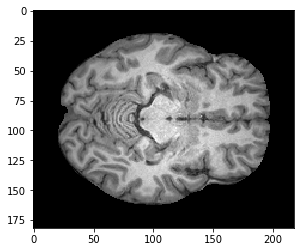

In [20]:
plt.imshow(img[0][:,:,60], cmap='gray')

In [21]:
torch.max(img[0])

tensor(1.)

In [22]:
torch.min(img[0])

tensor(-0.0375)

In [23]:
sample["label"]

tensor([1.])

# Define the classifier

In [24]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        self.Conv_5 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_5 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)

        self.classifier_scratch = nn.Sequential(
            nn.Linear(11200, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_5(x))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_5(x)) 
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [25]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [26]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 1303769


# Training

In [27]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-5
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

         # split train/validation
        train_df = data.sample(frac=0.8, random_state=32)
        val_df = data[~data["PTID"].isin(train_df["PTID"])]

        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        train_loader = DataLoader(
            ukb_data_train, batch_size=b, shuffle=True, num_workers=4
        )

        val_loader = DataLoader(
            ukb_data_val, batch_size=2, shuffle=True, num_workers=2
        )

        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=100,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric]))
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models

In [27]:
num_epochs = 200
min_iters = 3
ignore_epochs = 40
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [28]:
r = 3

In [30]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/full_set/baseline/"
callbacks = [EarlyStopping(patience=10, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

Starting trial 0
[0,   100] loss: 0.70281
Time elapsed: 0h:1m:59s
train accuracy_score: 50.67 %
train balanced_accuracy: 49.81 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.690827
[1,   100] loss: 0.69337
Time elapsed: 0h:4m:51s
train accuracy_score: 53.96 %
train balanced_accuracy: 52.80 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.696848
[2,   100] loss: 0.69396
Time elapsed: 0h:7m:36s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.35 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.682214
[3,   100] loss: 0.69108
Time elapsed: 0h:10m:18s
train accuracy_score: 51.10 %
train balanced_accuracy: 50.27 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.688135
[4,   100] loss: 0.69031
Time elapsed: 0h:13m:7s
train accuracy_score: 53.54 %
train balanced_accuracy: 52.43 %
val accuracy_score: 60.61 %
val balanced_accuracy: 58.16 %
Val loss: 0.688361
[5,   100] loss: 0.68870
Time el

[43,   100] loss: 0.23079
Time elapsed: 2h:2m:10s
train accuracy_score: 89.71 %
train balanced_accuracy: 89.76 %
val accuracy_score: 93.94 %
val balanced_accuracy: 94.10 %
Val loss: 0.139568
[44,   100] loss: 0.22485
Time elapsed: 2h:4m:54s
train accuracy_score: 91.48 %
train balanced_accuracy: 91.49 %
val accuracy_score: 92.26 %
val balanced_accuracy: 91.70 %
Val loss: 0.156679
[45,   100] loss: 0.22234
Time elapsed: 2h:7m:32s
train accuracy_score: 91.23 %
train balanced_accuracy: 91.18 %
val accuracy_score: 94.28 %
val balanced_accuracy: 94.40 %
Val loss: 0.147176
[46,   100] loss: 0.19061
Time elapsed: 2h:10m:9s
train accuracy_score: 91.32 %
train balanced_accuracy: 91.34 %
val accuracy_score: 93.60 %
val balanced_accuracy: 93.07 %
Val loss: 0.143497
[47,   100] loss: 0.20360
Time elapsed: 2h:12m:50s
train accuracy_score: 92.07 %
train balanced_accuracy: 92.06 %
val accuracy_score: 92.26 %
val balanced_accuracy: 91.62 %
Val loss: 0.162138
[48,   100] loss: 0.21047
Time elapsed: 2h:1

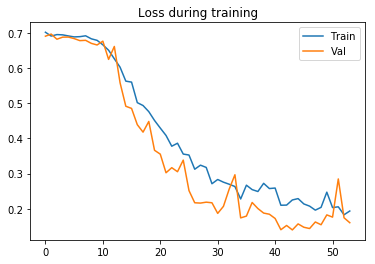

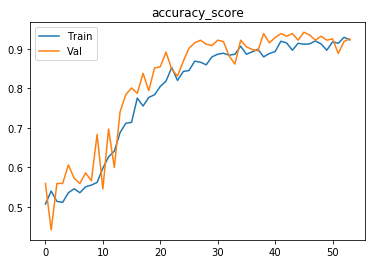

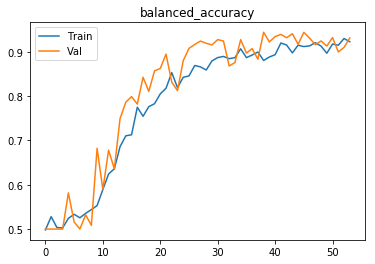

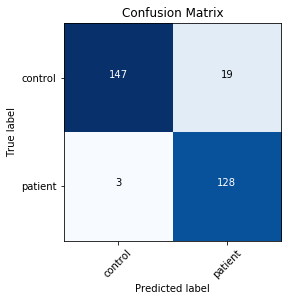

Starting trial 1
[0,   100] loss: 0.70323
Time elapsed: 0h:1m:56s
train accuracy_score: 51.01 %
train balanced_accuracy: 50.07 %
val accuracy_score: 44.44 %
val balanced_accuracy: 50.30 %
Val loss: 0.693857
[1,   100] loss: 0.69809
Time elapsed: 0h:4m:39s
train accuracy_score: 48.06 %
train balanced_accuracy: 47.43 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.688005
[2,   100] loss: 0.69730
Time elapsed: 0h:7m:15s
train accuracy_score: 50.84 %
train balanced_accuracy: 49.35 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.684640
[3,   100] loss: 0.69621
Time elapsed: 0h:10m:0s
train accuracy_score: 50.59 %
train balanced_accuracy: 49.08 %
val accuracy_score: 55.56 %
val balanced_accuracy: 59.36 %
Val loss: 0.691935
[4,   100] loss: 0.69563
Time elapsed: 0h:12m:42s
train accuracy_score: 53.46 %
train balanced_accuracy: 51.72 %
val accuracy_score: 56.90 %
val balanced_accuracy: 51.23 %
Val loss: 0.687269
[5,   100] loss: 0.69665
Time el

[43,   100] loss: 0.24369
Time elapsed: 2h:4m:12s
train accuracy_score: 89.71 %
train balanced_accuracy: 89.70 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.20 %
Val loss: 0.189028
[44,   100] loss: 0.23258
Time elapsed: 2h:7m:8s
train accuracy_score: 90.30 %
train balanced_accuracy: 90.27 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.35 %
Val loss: 0.176459
[45,   100] loss: 0.24164
Time elapsed: 2h:10m:5s
train accuracy_score: 89.38 %
train balanced_accuracy: 89.38 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.69 %
Val loss: 0.201267
[46,   100] loss: 0.21867
Time elapsed: 2h:13m:6s
train accuracy_score: 90.89 %
train balanced_accuracy: 90.86 %
val accuracy_score: 90.57 %
val balanced_accuracy: 91.16 %
Val loss: 0.199099
[47,   100] loss: 0.21378
Time elapsed: 2h:16m:5s
train accuracy_score: 90.89 %
train balanced_accuracy: 90.88 %
val accuracy_score: 91.92 %
val balanced_accuracy: 92.13 %
Val loss: 0.177390
[48,   100] loss: 0.21223
Time elapsed: 2h:19m

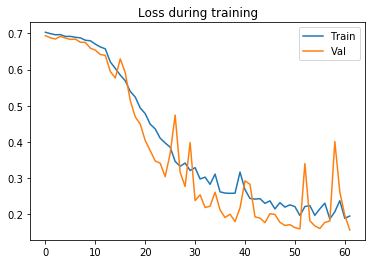

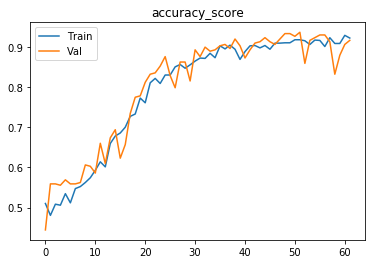

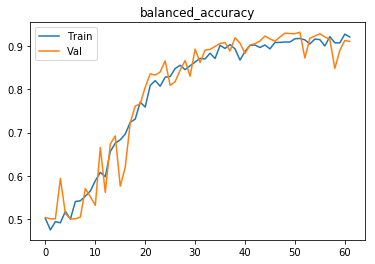

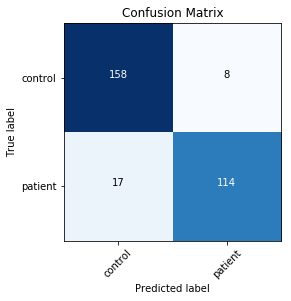

Starting trial 2
[0,   100] loss: 0.70096
Time elapsed: 0h:1m:57s
train accuracy_score: 50.59 %
train balanced_accuracy: 49.19 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.690085
[1,   100] loss: 0.69649
Time elapsed: 0h:4m:49s
train accuracy_score: 49.66 %
train balanced_accuracy: 47.99 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.688396
[2,   100] loss: 0.69609
Time elapsed: 0h:7m:40s
train accuracy_score: 52.61 %
train balanced_accuracy: 51.36 %
val accuracy_score: 55.22 %
val balanced_accuracy: 49.40 %
Val loss: 0.683033
[3,   100] loss: 0.69750
Time elapsed: 0h:10m:30s
train accuracy_score: 52.11 %
train balanced_accuracy: 50.90 %
val accuracy_score: 53.87 %
val balanced_accuracy: 48.27 %
Val loss: 0.690253
[4,   100] loss: 0.69215
Time elapsed: 0h:13m:26s
train accuracy_score: 53.46 %
train balanced_accuracy: 51.18 %
val accuracy_score: 57.91 %
val balanced_accuracy: 60.34 %
Val loss: 0.689756
[5,   100] loss: 0.68642
Time e

[43,   100] loss: 0.27166
Time elapsed: 2h:4m:35s
train accuracy_score: 88.45 %
train balanced_accuracy: 88.40 %
val accuracy_score: 88.55 %
val balanced_accuracy: 88.95 %
Val loss: 0.231548
[44,   100] loss: 0.23478
Time elapsed: 2h:7m:27s
train accuracy_score: 89.97 %
train balanced_accuracy: 89.91 %
val accuracy_score: 88.55 %
val balanced_accuracy: 89.12 %
Val loss: 0.229614
[45,   100] loss: 0.21713
Time elapsed: 2h:10m:17s
train accuracy_score: 89.71 %
train balanced_accuracy: 89.71 %
val accuracy_score: 90.57 %
val balanced_accuracy: 90.76 %
Val loss: 0.201959
[46,   100] loss: 0.20678
Time elapsed: 2h:13m:8s
train accuracy_score: 89.97 %
train balanced_accuracy: 89.97 %
val accuracy_score: 90.57 %
val balanced_accuracy: 90.44 %
Val loss: 0.193268
[47,   100] loss: 0.24756
Time elapsed: 2h:15m:59s
train accuracy_score: 89.04 %
train balanced_accuracy: 89.05 %
val accuracy_score: 89.56 %
val balanced_accuracy: 90.34 %
Val loss: 0.243936
[48,   100] loss: 0.26010
Time elapsed: 2h:

[86,   100] loss: 0.16284
Time elapsed: 4h:7m:42s
train accuracy_score: 93.59 %
train balanced_accuracy: 93.55 %
val accuracy_score: 92.93 %
val balanced_accuracy: 93.51 %
Val loss: 0.178727
[87,   100] loss: 0.17300
Time elapsed: 4h:10m:34s
train accuracy_score: 92.41 %
train balanced_accuracy: 92.40 %
val accuracy_score: 92.26 %
val balanced_accuracy: 91.78 %
Val loss: 0.140236
[88,   100] loss: 0.12612
Time elapsed: 4h:13m:28s
train accuracy_score: 94.60 %
train balanced_accuracy: 94.62 %
val accuracy_score: 93.60 %
val balanced_accuracy: 93.87 %
Val loss: 0.137236
[89,   100] loss: 0.13001
Time elapsed: 4h:16m:20s
train accuracy_score: 94.27 %
train balanced_accuracy: 94.28 %
val accuracy_score: 93.60 %
val balanced_accuracy: 93.71 %
Val loss: 0.133557
[90,   100] loss: 0.15797
Time elapsed: 4h:19m:14s
train accuracy_score: 93.84 %
train balanced_accuracy: 93.83 %
val accuracy_score: 92.93 %
val balanced_accuracy: 92.63 %
Val loss: 0.146353
[91,   100] loss: 0.17022
Time elapsed: 4

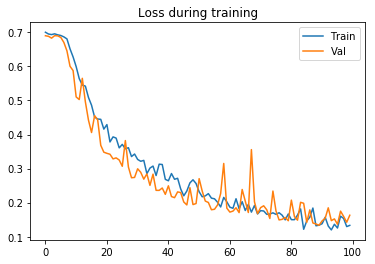

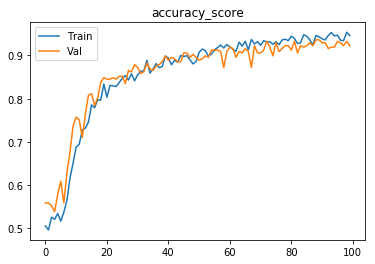

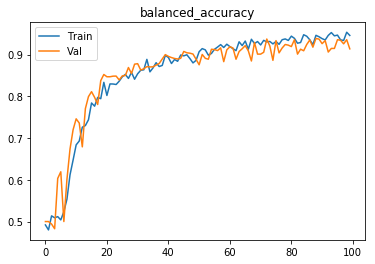

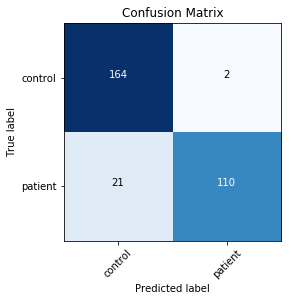

Starting trial 3
[0,   100] loss: 0.70246
Time elapsed: 0h:1m:58s
train accuracy_score: 52.19 %
train balanced_accuracy: 51.00 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.685683
[1,   100] loss: 0.70357
Time elapsed: 0h:4m:47s
train accuracy_score: 50.17 %
train balanced_accuracy: 48.83 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.691131
[2,   100] loss: 0.69572
Time elapsed: 0h:7m:38s
train accuracy_score: 52.11 %
train balanced_accuracy: 50.43 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.691766
[3,   100] loss: 0.69591
Time elapsed: 0h:10m:28s
train accuracy_score: 52.53 %
train balanced_accuracy: 51.11 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.689828
[4,   100] loss: 0.69456
Time elapsed: 0h:13m:18s
train accuracy_score: 51.60 %
train balanced_accuracy: 49.75 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.689750
[5,   100] loss: 0.69276
Time e

[43,   100] loss: 0.25125
Time elapsed: 2h:4m:27s
train accuracy_score: 90.30 %
train balanced_accuracy: 90.27 %
val accuracy_score: 92.26 %
val balanced_accuracy: 91.46 %
Val loss: 0.176039
[44,   100] loss: 0.23686
Time elapsed: 2h:7m:16s
train accuracy_score: 90.30 %
train balanced_accuracy: 90.27 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.16 %
Val loss: 0.169020
[45,   100] loss: 0.21510
Time elapsed: 2h:10m:4s
train accuracy_score: 90.39 %
train balanced_accuracy: 90.36 %
val accuracy_score: 94.28 %
val balanced_accuracy: 93.75 %
Val loss: 0.159484
[46,   100] loss: 0.22589
Time elapsed: 2h:12m:53s
train accuracy_score: 91.23 %
train balanced_accuracy: 91.25 %
val accuracy_score: 93.60 %
val balanced_accuracy: 93.79 %
Val loss: 0.153722
[47,   100] loss: 0.24053
Time elapsed: 2h:15m:42s
train accuracy_score: 91.40 %
train balanced_accuracy: 91.41 %
val accuracy_score: 92.93 %
val balanced_accuracy: 93.19 %
Val loss: 0.164690
[48,   100] loss: 0.20744
Time elapsed: 2h:

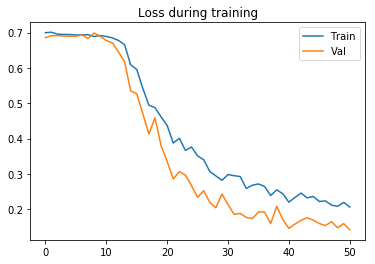

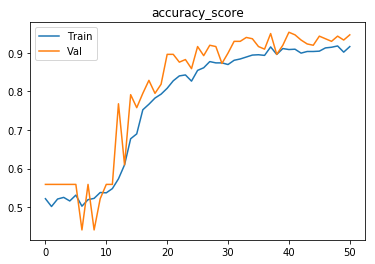

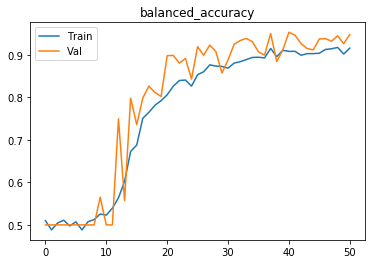

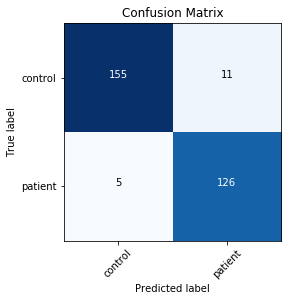

Starting trial 4
[0,   100] loss: 0.69104
Time elapsed: 0h:1m:52s
train accuracy_score: 52.45 %
train balanced_accuracy: 51.89 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.695769
[1,   100] loss: 0.69973
Time elapsed: 0h:4m:42s
train accuracy_score: 52.95 %
train balanced_accuracy: 52.40 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.686232
[2,   100] loss: 0.69713
Time elapsed: 0h:7m:33s
train accuracy_score: 51.69 %
train balanced_accuracy: 50.56 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.688155
[3,   100] loss: 0.69454
Time elapsed: 0h:10m:23s
train accuracy_score: 51.85 %
train balanced_accuracy: 50.52 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.684549
[4,   100] loss: 0.69234
Time elapsed: 0h:13m:13s
train accuracy_score: 52.78 %
train balanced_accuracy: 51.06 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.682911
[5,   100] loss: 0.69446
Time e

[43,   100] loss: 0.24686
Time elapsed: 2h:3m:32s
train accuracy_score: 89.29 %
train balanced_accuracy: 89.29 %
val accuracy_score: 86.87 %
val balanced_accuracy: 85.19 %
Val loss: 0.299010
[44,   100] loss: 0.21597
Time elapsed: 2h:6m:21s
train accuracy_score: 90.81 %
train balanced_accuracy: 90.77 %
val accuracy_score: 92.93 %
val balanced_accuracy: 92.95 %
Val loss: 0.174940
[45,   100] loss: 0.20967
Time elapsed: 2h:9m:10s
train accuracy_score: 91.23 %
train balanced_accuracy: 91.22 %
val accuracy_score: 89.90 %
val balanced_accuracy: 89.19 %
Val loss: 0.201954
[46,   100] loss: 0.20075
Time elapsed: 2h:11m:59s
train accuracy_score: 91.82 %
train balanced_accuracy: 91.79 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.33 %
Val loss: 0.193464
[47,   100] loss: 0.18614
Time elapsed: 2h:14m:47s
train accuracy_score: 92.58 %
train balanced_accuracy: 92.60 %
val accuracy_score: 90.57 %
val balanced_accuracy: 89.80 %
Val loss: 0.183422
[48,   100] loss: 0.19025
Time elapsed: 2h:

[86,   100] loss: 0.15801
Time elapsed: 4h:5m:45s
train accuracy_score: 94.10 %
train balanced_accuracy: 94.11 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.48 %
Val loss: 0.148969
[87,   100] loss: 0.13580
Time elapsed: 4h:8m:35s
train accuracy_score: 93.93 %
train balanced_accuracy: 93.93 %
val accuracy_score: 90.57 %
val balanced_accuracy: 91.49 %
Val loss: 0.241590
[88,   100] loss: 0.12479
Time elapsed: 4h:11m:24s
train accuracy_score: 95.03 %
train balanced_accuracy: 95.01 %
val accuracy_score: 91.58 %
val balanced_accuracy: 91.10 %
Val loss: 0.165742
Early stopping in epoch 89
Total time elapsed: 4h:12m:19s
Writing model to disk...
Best result during training: 0.94. Saving model..
Finished fold.


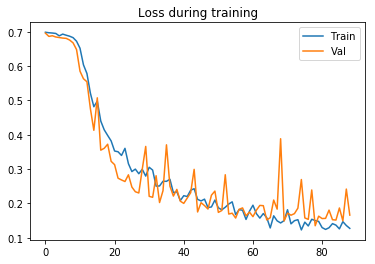

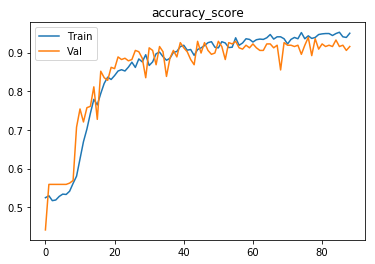

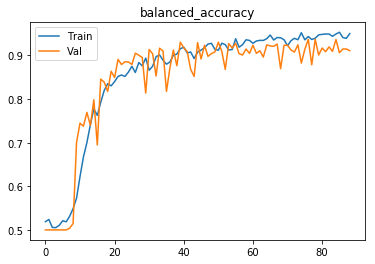

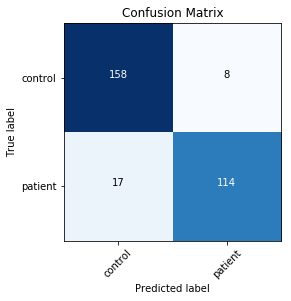

Starting trial 5
[0,   100] loss: 0.70019
Time elapsed: 0h:1m:55s
train accuracy_score: 49.41 %
train balanced_accuracy: 48.55 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.687164
[1,   100] loss: 0.69703
Time elapsed: 0h:4m:46s
train accuracy_score: 52.78 %
train balanced_accuracy: 50.87 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.686868
[2,   100] loss: 0.69790
Time elapsed: 0h:7m:39s
train accuracy_score: 51.85 %
train balanced_accuracy: 50.69 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.687491
[3,   100] loss: 0.69427
Time elapsed: 0h:10m:32s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.49 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.685430
[4,   100] loss: 0.69013
Time elapsed: 0h:13m:25s
train accuracy_score: 53.29 %
train balanced_accuracy: 51.50 %
val accuracy_score: 65.66 %
val balanced_accuracy: 62.92 %
Val loss: 0.687758
[5,   100] loss: 0.68661
Time e

[43,   100] loss: 0.23449
Time elapsed: 2h:1m:37s
train accuracy_score: 91.32 %
train balanced_accuracy: 91.34 %
val accuracy_score: 91.92 %
val balanced_accuracy: 92.29 %
Val loss: 0.173110
[44,   100] loss: 0.19398
Time elapsed: 2h:4m:18s
train accuracy_score: 91.32 %
train balanced_accuracy: 91.29 %
val accuracy_score: 89.23 %
val balanced_accuracy: 90.28 %
Val loss: 0.269295
[45,   100] loss: 0.18769
Time elapsed: 2h:6m:57s
train accuracy_score: 92.83 %
train balanced_accuracy: 92.86 %
val accuracy_score: 92.93 %
val balanced_accuracy: 93.35 %
Val loss: 0.176129
[46,   100] loss: 0.21525
Time elapsed: 2h:9m:36s
train accuracy_score: 91.99 %
train balanced_accuracy: 91.97 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.59 %
Val loss: 0.171807
[47,   100] loss: 0.18938
Time elapsed: 2h:12m:17s
train accuracy_score: 92.07 %
train balanced_accuracy: 92.03 %
val accuracy_score: 86.20 %
val balanced_accuracy: 87.65 %
Val loss: 0.330314
[48,   100] loss: 0.21162
Time elapsed: 2h:1

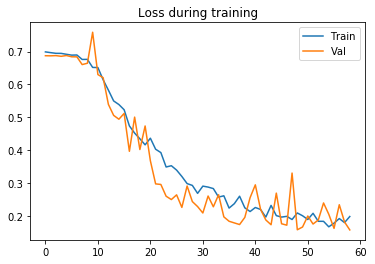

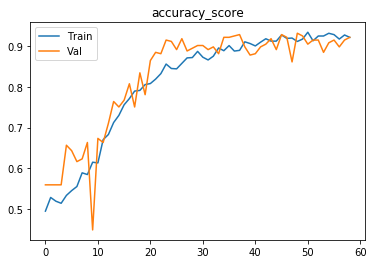

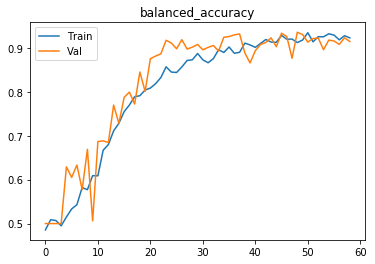

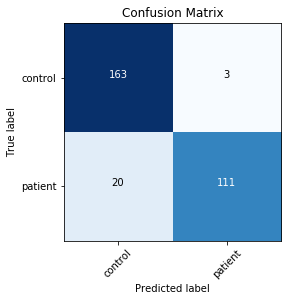

Starting trial 6
[0,   100] loss: 0.70247
Time elapsed: 0h:1m:47s
train accuracy_score: 51.69 %
train balanced_accuracy: 50.63 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.698737
[1,   100] loss: 0.69807
Time elapsed: 0h:4m:36s
train accuracy_score: 52.70 %
train balanced_accuracy: 51.77 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.690121
[2,   100] loss: 0.69317
Time elapsed: 0h:7m:18s
train accuracy_score: 52.61 %
train balanced_accuracy: 50.84 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.686433
[3,   100] loss: 0.69666
Time elapsed: 0h:10m:4s
train accuracy_score: 50.42 %
train balanced_accuracy: 48.91 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.685087
[4,   100] loss: 0.68808
Time elapsed: 0h:12m:43s
train accuracy_score: 53.04 %
train balanced_accuracy: 51.17 %
val accuracy_score: 61.28 %
val balanced_accuracy: 62.54 %
Val loss: 0.689411
[5,   100] loss: 0.69101
Time el

[43,   100] loss: 0.21804
Time elapsed: 1h:56m:46s
train accuracy_score: 90.89 %
train balanced_accuracy: 90.87 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.41 %
Val loss: 0.156073
[44,   100] loss: 0.20815
Time elapsed: 1h:59m:28s
train accuracy_score: 91.74 %
train balanced_accuracy: 91.70 %
val accuracy_score: 91.58 %
val balanced_accuracy: 90.94 %
Val loss: 0.169786
[45,   100] loss: 0.17943
Time elapsed: 2h:2m:12s
train accuracy_score: 92.75 %
train balanced_accuracy: 92.74 %
val accuracy_score: 91.92 %
val balanced_accuracy: 92.61 %
Val loss: 0.204008
[46,   100] loss: 0.17758
Time elapsed: 2h:4m:52s
train accuracy_score: 93.34 %
train balanced_accuracy: 93.34 %
val accuracy_score: 93.60 %
val balanced_accuracy: 93.71 %
Val loss: 0.153605
[47,   100] loss: 0.18376
Time elapsed: 2h:7m:38s
train accuracy_score: 92.83 %
train balanced_accuracy: 92.80 %
val accuracy_score: 92.26 %
val balanced_accuracy: 91.70 %
Val loss: 0.148850
[48,   100] loss: 0.18052
Time elapsed: 2h:

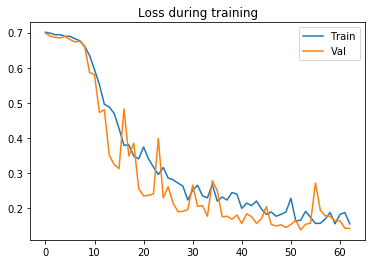

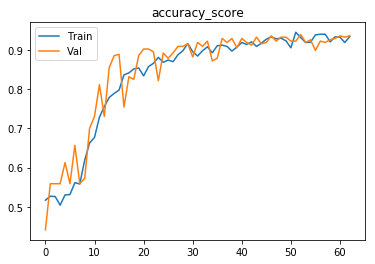

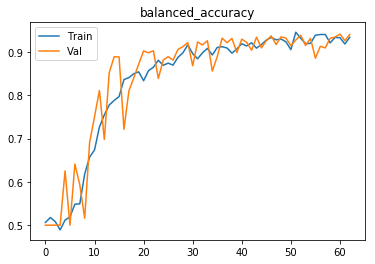

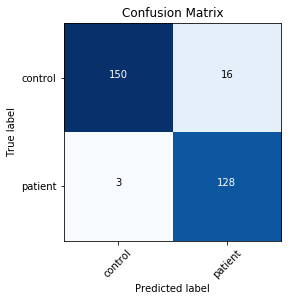

Starting trial 7
[0,   100] loss: 0.69865
Time elapsed: 0h:1m:50s
train accuracy_score: 52.45 %
train balanced_accuracy: 51.36 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.686229
[1,   100] loss: 0.70109
Time elapsed: 0h:4m:30s
train accuracy_score: 52.95 %
train balanced_accuracy: 51.41 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.685115
[2,   100] loss: 0.69549
Time elapsed: 0h:7m:13s
train accuracy_score: 50.34 %
train balanced_accuracy: 48.47 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.686443
[3,   100] loss: 0.69342
Time elapsed: 0h:9m:55s
train accuracy_score: 52.11 %
train balanced_accuracy: 50.37 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.683793
[4,   100] loss: 0.69028
Time elapsed: 0h:12m:37s
train accuracy_score: 54.55 %
train balanced_accuracy: 52.56 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.702738
[5,   100] loss: 0.69289
Time el

[43,   100] loss: 0.17399
Time elapsed: 1h:57m:15s
train accuracy_score: 92.75 %
train balanced_accuracy: 92.74 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.40 %
Val loss: 0.174209
[44,   100] loss: 0.18679
Time elapsed: 1h:59m:51s
train accuracy_score: 92.07 %
train balanced_accuracy: 92.09 %
val accuracy_score: 89.90 %
val balanced_accuracy: 90.80 %
Val loss: 0.232169
[45,   100] loss: 0.17320
Time elapsed: 2h:2m:37s
train accuracy_score: 92.41 %
train balanced_accuracy: 92.38 %
val accuracy_score: 90.57 %
val balanced_accuracy: 91.41 %
Val loss: 0.230600
[46,   100] loss: 0.19900
Time elapsed: 2h:5m:22s
train accuracy_score: 92.50 %
train balanced_accuracy: 92.46 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.49 %
Val loss: 0.174278
[47,   100] loss: 0.20225
Time elapsed: 2h:8m:10s
train accuracy_score: 93.17 %
train balanced_accuracy: 93.14 %
val accuracy_score: 92.93 %
val balanced_accuracy: 93.19 %
Val loss: 0.165835
[48,   100] loss: 0.18007
Time elapsed: 2h:

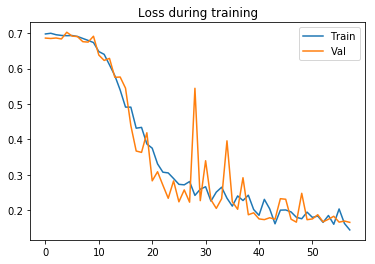

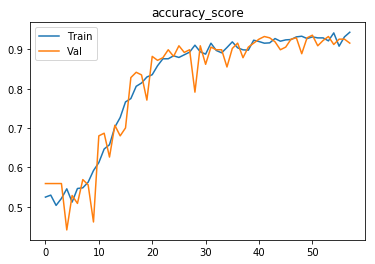

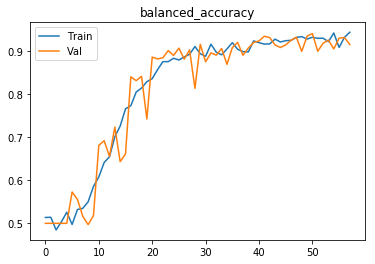

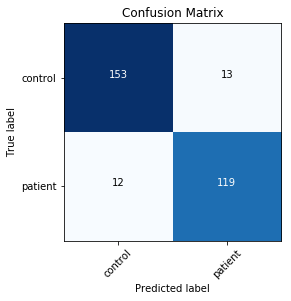

Starting trial 8
[0,   100] loss: 0.70021
Time elapsed: 0h:1m:48s
train accuracy_score: 51.18 %
train balanced_accuracy: 49.99 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.706125
[1,   100] loss: 0.70121
Time elapsed: 0h:4m:26s
train accuracy_score: 50.51 %
train balanced_accuracy: 49.21 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.697311
[2,   100] loss: 0.69430
Time elapsed: 0h:7m:11s
train accuracy_score: 52.36 %
train balanced_accuracy: 50.88 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.682581
[3,   100] loss: 0.69196
Time elapsed: 0h:9m:51s
train accuracy_score: 51.94 %
train balanced_accuracy: 50.68 %
val accuracy_score: 67.34 %
val balanced_accuracy: 68.37 %
Val loss: 0.688369
[4,   100] loss: 0.69255
Time elapsed: 0h:12m:26s
train accuracy_score: 53.46 %
train balanced_accuracy: 52.12 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.674123
[5,   100] loss: 0.68943
Time el

[43,   100] loss: 0.19716
Time elapsed: 1h:58m:10s
train accuracy_score: 91.99 %
train balanced_accuracy: 91.97 %
val accuracy_score: 94.28 %
val balanced_accuracy: 94.40 %
Val loss: 0.133392
[44,   100] loss: 0.20679
Time elapsed: 2h:0m:50s
train accuracy_score: 92.24 %
train balanced_accuracy: 92.21 %
val accuracy_score: 91.92 %
val balanced_accuracy: 92.53 %
Val loss: 0.191894
[45,   100] loss: 0.19997
Time elapsed: 2h:3m:37s
train accuracy_score: 91.74 %
train balanced_accuracy: 91.70 %
val accuracy_score: 92.59 %
val balanced_accuracy: 93.21 %
Val loss: 0.178313
[46,   100] loss: 0.17674
Time elapsed: 2h:6m:18s
train accuracy_score: 92.58 %
train balanced_accuracy: 92.56 %
val accuracy_score: 94.28 %
val balanced_accuracy: 94.64 %
Val loss: 0.147128
[47,   100] loss: 0.16173
Time elapsed: 2h:8m:58s
train accuracy_score: 93.25 %
train balanced_accuracy: 93.23 %
val accuracy_score: 89.23 %
val balanced_accuracy: 87.87 %
Val loss: 0.204162
[48,   100] loss: 0.20628
Time elapsed: 2h:1

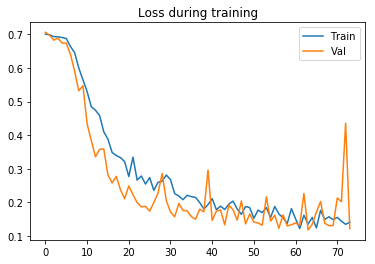

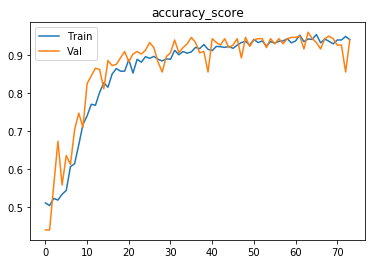

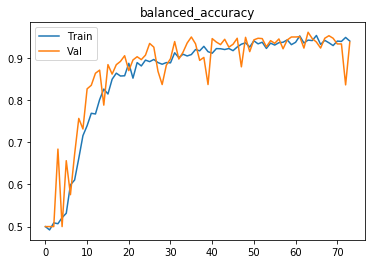

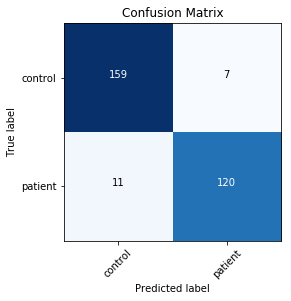

Starting trial 9
[0,   100] loss: 0.70418
Time elapsed: 0h:1m:57s
train accuracy_score: 50.84 %
train balanced_accuracy: 49.95 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.686153
[1,   100] loss: 0.69933
Time elapsed: 0h:4m:52s
train accuracy_score: 49.83 %
train balanced_accuracy: 48.71 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.688580
[2,   100] loss: 0.69630
Time elapsed: 0h:7m:49s
train accuracy_score: 50.93 %
train balanced_accuracy: 49.19 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.694423
[3,   100] loss: 0.69374
Time elapsed: 0h:10m:47s
train accuracy_score: 53.29 %
train balanced_accuracy: 51.78 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.683526
[4,   100] loss: 0.69380
Time elapsed: 0h:13m:40s
train accuracy_score: 51.52 %
train balanced_accuracy: 50.41 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.687836
[5,   100] loss: 0.69025
Time e

[43,   100] loss: 0.21240
Time elapsed: 2h:8m:17s
train accuracy_score: 91.48 %
train balanced_accuracy: 91.48 %
val accuracy_score: 91.25 %
val balanced_accuracy: 90.72 %
Val loss: 0.184549
[44,   100] loss: 0.20974
Time elapsed: 2h:11m:14s
train accuracy_score: 90.30 %
train balanced_accuracy: 90.28 %
val accuracy_score: 91.58 %
val balanced_accuracy: 90.70 %
Val loss: 0.184139
[45,   100] loss: 0.22153
Time elapsed: 2h:14m:11s
train accuracy_score: 89.88 %
train balanced_accuracy: 89.89 %
val accuracy_score: 90.91 %
val balanced_accuracy: 91.63 %
Val loss: 0.224366
[46,   100] loss: 0.20835
Time elapsed: 2h:17m:7s
train accuracy_score: 89.71 %
train balanced_accuracy: 89.61 %
val accuracy_score: 89.90 %
val balanced_accuracy: 90.80 %
Val loss: 0.251575
[47,   100] loss: 0.22321
Time elapsed: 2h:20m:0s
train accuracy_score: 92.07 %
train balanced_accuracy: 92.05 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.93 %
Val loss: 0.206384
[48,   100] loss: 0.21857
Time elapsed: 2h:

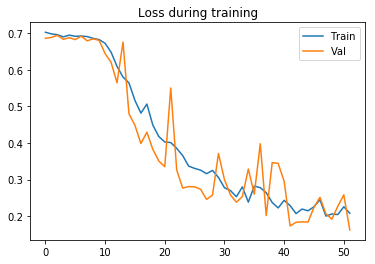

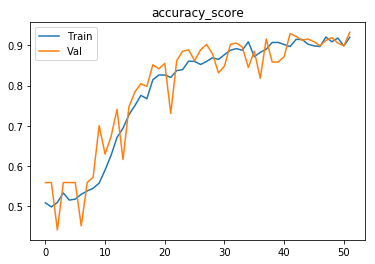

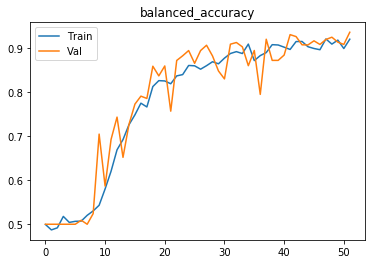

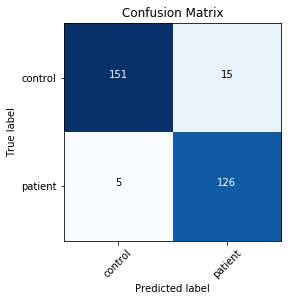

################################
################################
All accuracies: [0.93132070265796, 0.9110181182746252, 0.9138232318587326, 0.9477835004138692, 0.9110181182746252, 0.9146279775590914, 0.9403568472362733, 0.9150418467764185, 0.9369309298261749, 0.9357353076427849]
Best accuracies mean: 0.9418996597075324 All :[0.944173641129403, 0.9323093902326864, 0.9387473558355559, 0.9530028510990527, 0.9371378644348386, 0.9357353076427849, 0.9411615929366319, 0.9403568472362733, 0.9606364388853122, 0.9357353076427849]
0.9257656580520557
0.013301328387797783


In [31]:
fold_metric, models = run(net=net, data=train_df,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  augmentations=augmentations,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [32]:
5/0

ZeroDivisionError: division by zero

# Start inference

### Using best model checkpoint for inference

In [31]:
if zero_one_normalize:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
else:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
            
test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [32]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [33]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Fold 0
Bal. accuracy 92.222 %
ROC AUC Score 97.695 %
Sensitivity 92.500 %
Specificity 91.943 %
Fold 1
Bal. accuracy 93.794 %
ROC AUC Score 98.137 %
Sensitivity 93.750 %
Specificity 93.839 %
Fold 2
Bal. accuracy 94.807 %
ROC AUC Score 98.572 %
Sensitivity 96.250 %
Specificity 93.365 %
Fold 3
Bal. accuracy 94.021 %
ROC AUC Score 97.861 %
Sensitivity 95.625 %
Specificity 92.417 %
Fold 4
Bal. accuracy 93.945 %
ROC AUC Score 98.380 %
Sensitivity 95.000 %
Specificity 92.891 %
Fold 5
Bal. accuracy 93.709 %
ROC AUC Score 98.241 %
Sensitivity 95.000 %
Specificity 92.417 %
Fold 6
Bal. accuracy 92.836 %
ROC AUC Score 98.051 %
Sensitivity 95.625 %
Specificity 90.047 %
Fold 7
Bal. accuracy 93.698 %
ROC AUC Score 98.436 %
Sensitivity 96.875 %
Specificity 90.521 %
Fold 8
Bal. accuracy 94.722 %
ROC AUC Score 98.300 %
Sensitivity 97.500 %
Specificity 91.943 %
Fold 9
Bal. accuracy 92.685 %
ROC AUC Score 97.882 %
Sensitivity 94.375 %
Specificity 90.995 %
######## Final results ########
    Bal Acc   ROC 